In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


dataset path

In [ ]:
# Base dataset path
base_path = "/content/drive/MyDrive/fyp/dataset"

# Check the folders
import os
for split in ["train", "test", "valid"]:
    path = os.path.join(base_path, split)
    print(split, "->", os.listdir(path)[:5])  # show first 5 items


train -> ['P06907_jpg.rf.d87955fe144cff696711d743ac59e74d.jpg', 'P06473_jpg.rf.bb5515598abe7c2fad8d378e01d575f4.jpg', 'P06486_jpg.rf.6c92df5b159490ea8bcbdeace39fa9f6.jpg', 'P03797_jpg.rf.381a72a3f6fcfa63394856c83a01d42f.jpg', 'P02655_jpg.rf.d64ad64f2132d0367d56e12d09f74936.jpg']
test -> ['P03456_jpg.rf.38c3efcb05bb520b29ad071cff56ccf7.jpg', 'P02595_jpg.rf.15be3c4e0b57de7784378876f88c9629.jpg', 'P07285_jpg.rf.06814d349808f84e94fee3ab8e54e96b.jpg', 'P00682_jpg.rf.2c3b05570cea2d8877b50c637ed43fdd.jpg', 'P04840_jpg.rf.898723d9dd6fcf90056706f69c451f5a.jpg']
valid -> ['P03367_jpg.rf.337d55f1f529a5dd8e1fba6746ca0321.jpg', 'P07523_jpg.rf.173d257c09cc84e58d0fe177757caae0.jpg', 'P07131_jpg.rf.1bd7d1d627a481889beb0238ededeabd.jpg', 'P03532_jpg.rf.019c457057638870fb89ccae3bca9184.jpg', 'P00397_jpg.rf.1738aa6129453b2882f4ebbc4204fe15.jpg']


feature wise plot


===== TRAIN SET =====
class
Gun         1508
Pliers      1351
Knife       1347
Wrench      1318
Scissors    1188


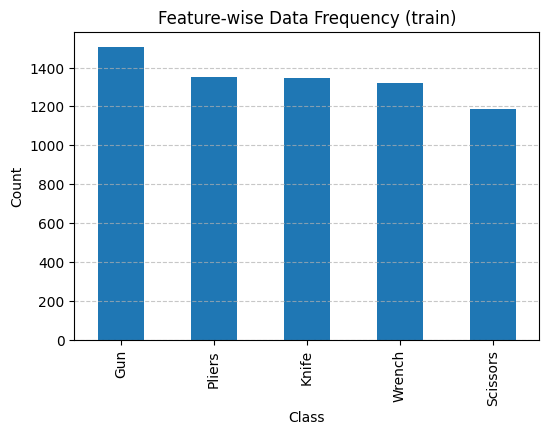


===== TEST SET =====
class
Knife       88
Gun         81
Wrench      68
Pliers      67
Scissors    54


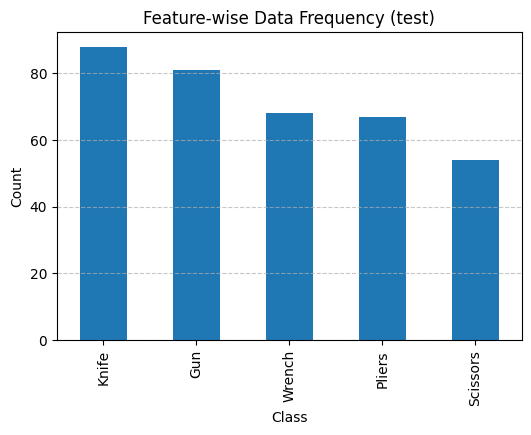


===== VALID SET =====
class
Gun         162
Knife       159
Wrench      132
Scissors    127
Pliers      124


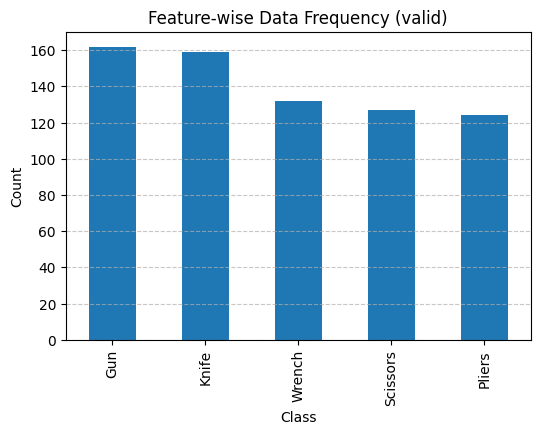

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

base_path = "/content/drive/MyDrive/fyp/dataset"

# Loop over each split
for split in ["train", "test", "valid"]:
    csv_path = os.path.join(base_path, split, "_annotations.csv")
    df = pd.read_csv(csv_path)

    # Plot class frequency
    counts = df["class"].value_counts()

    print(f"\n===== {split.upper()} SET =====")
    print(counts.to_string())  # <- This removes the dtype line

    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title(f"Feature-wise Data Frequency ({split})")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

databalancing

In [ ]:
import os
import pandas as pd
from PIL import Image, ImageEnhance
import random
from tqdm import tqdm
import shutil

# ===== Paths =====
train_csv = "/content/drive/MyDrive/fyp/dataset/train/_annotations.csv"
train_img_folder = "/content/drive/MyDrive/fyp/dataset/train"
aug_img_folder = "/content/drive/MyDrive/fyp/aug_img"
aug_label_folder = os.path.join(aug_img_folder, "labels_yolo")
os.makedirs(aug_img_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

# ===== Load training CSV =====
df = pd.read_csv(train_csv)

# ===== Class counts & target =====
class_counts = df['class'].value_counts()
max_count = class_counts.max()
print("Original class counts:")
print(class_counts.to_string())
print(f"Target per class: {max_count}")

# ===== Helper: augmentation function =====
def augment_image_and_bboxes(img, bboxes):
    """
    img: PIL.Image
    bboxes: list of [xmin, ymin, xmax, ymax]
    returns: aug_img, new_bboxes
    """
    w, h = img.size
    choice = random.choice(['rotate','flip','brightness'])
    new_bboxes = []

    if choice == 'rotate':
        angle = random.choice([15, -15])
        img = img.rotate(angle, expand=True)
        # NOTE: rotated boxes are not adjusted here, can implement rotation later
        new_bboxes = bboxes

    elif choice == 'flip':
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        for xmin, ymin, xmax, ymax in bboxes:
            new_xmin = w - xmax
            new_xmax = w - xmin
            new_bboxes.append([new_xmin, ymin, new_xmax, ymax])

    elif choice == 'brightness':
        factor = random.uniform(0.7, 1.3)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(factor)
        new_bboxes = bboxes

    return img, new_bboxes

# ===== Group rows by filename =====
image_groups = df.groupby('filename')

# ===== First: copy original images and create YOLO labels =====
print("Copying original images and generating YOLO labels...")
for filename, group in tqdm(image_groups):
    img_path = os.path.join(train_img_folder, filename)
    try:
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
    except:
        continue

    # Save original image
    save_name = f"orig_{filename}"
    img.save(os.path.join(aug_img_folder, save_name))

    # YOLO label for all boxes in image
    txt_lines = []
    for _, row in group.iterrows():
        cls = row['class']
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        x_center = (xmin + xmax) / 2 / w
        y_center = (ymin + ymax) / 2 / h
        width = (xmax - xmin) / w
        height = (ymax - ymin) / h
        txt_lines.append(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Save label
    txt_path = os.path.join(aug_label_folder, os.path.splitext(save_name)[0] + ".txt")
    with open(txt_path, "w") as f:
        f.write("\n".join(txt_lines))

# ===== Now: augment to balance classes =====
print("\nPerforming data augmentation to balance classes...")
for cls, count in class_counts.items():
    needed = max_count - count
    if needed <= 0:
        continue
    print(f"Augmenting class '{cls}' → {needed} new samples needed")

    # Get images that contain this class
    cls_rows = df[df['class'] == cls]
    cls_images = cls_rows['filename'].unique()

    for i in tqdm(range(needed), desc=f"Augmenting {cls}"):
        # Randomly pick an image containing this class
        img_file = random.choice(cls_images)
        group = df[df['filename'] == img_file]

        img_path = os.path.join(train_img_folder, img_file)
        try:
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            bboxes = group[['xmin','ymin','xmax','ymax']].values.tolist()
            classes = group['class'].tolist()

            # Augment whole image
            aug_img, aug_bboxes = augment_image_and_bboxes(img, bboxes)

            # Save augmented image
            aug_name = f"aug_{cls}_{i}_{img_file}"
            aug_img.save(os.path.join(aug_img_folder, aug_name))

            # Save YOLO label for ALL boxes in augmented image
            txt_lines = []
            for c, bbox in zip(classes, aug_bboxes):
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2 / w
                y_center = (ymin + ymax) / 2 / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h
                txt_lines.append(f"{c} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

            txt_path = os.path.join(aug_label_folder, os.path.splitext(aug_name)[0] + ".txt")
            with open(txt_path, "w") as f:
                f.write("\n".join(txt_lines))

        except:
            continue

print("\nData balancing complete! All images and YOLO labels ready.")


Original class counts:
class
Gun         1508
Pliers      1351
Knife       1347
Wrench      1318
Scissors    1188
Target per class: 1508
Copying original images and generating YOLO labels...


100%|██████████| 3302/3302 [17:59<00:00,  3.06it/s]



Performing data augmentation to balance classes...
Augmenting class 'Pliers' → 157 new samples needed


Augmenting Pliers: 100%|██████████| 157/157 [00:03<00:00, 48.39it/s]


Augmenting class 'Knife' → 161 new samples needed


Augmenting Knife: 100%|██████████| 161/161 [00:03<00:00, 44.32it/s]


Augmenting class 'Wrench' → 190 new samples needed


Augmenting Wrench: 100%|██████████| 190/190 [00:04<00:00, 45.12it/s]


Augmenting class 'Scissors' → 320 new samples needed


Augmenting Scissors: 100%|██████████| 320/320 [00:06<00:00, 46.43it/s]


Data balancing complete! All images and YOLO labels ready.


Custom k anchor means

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# ===== Paths =====
aug_label_folder = "/content/drive/MyDrive/fyp/aug_img/labels_yolo"
save_anchors_path = "/content/drive/MyDrive/fyp/aug_img/custom_anchors.npy"

# ===== Load all bounding boxes =====
all_boxes = []
label_files = [f for f in os.listdir(aug_label_folder) if f.endswith('.txt')]

for label_file in label_files:
    txt_path = os.path.join(aug_label_folder, label_file)
    with open(txt_path, 'r') as f:
        lines = f.read().strip().split("\n")
        for line in lines:
            if line:
                parts = line.strip().split()
                cls = parts[0]
                x_center, y_center, width, height = map(float, parts[1:])
                # Convert to pixel values assuming 416x416 input size
                w_px = width * 416
                h_px = height * 416
                all_boxes.append([w_px, h_px])

all_boxes = np.array(all_boxes)

# ===== K-Means for anchors =====
num_anchors = 9  # YOLOv3 default
kmeans = KMeans(n_clusters=num_anchors, random_state=42)
kmeans.fit(all_boxes)
anchors = kmeans.cluster_centers_

# Sort anchors by width for convenience
anchors = anchors[np.argsort(anchors[:, 0])]

# ===== Save anchors =====
np.save(save_anchors_path, anchors)

# ===== Summary =====
print(f"Custom anchors computed and saved to: {save_anchors_path}")
print("Anchors (width, height in pixels):")
for i, (w, h) in enumerate(anchors):
    print(f"{i+1}: {w:.2f} x {h:.2f}")

Custom anchors computed and saved to: /content/drive/MyDrive/fyp/aug_img/custom_anchors.npy
Anchors (width, height in pixels):
1: 45.44 x 66.40
2: 77.54 x 134.55
3: 85.03 x 238.84
4: 89.43 x 62.40
5: 138.92 x 81.00
6: 159.18 x 170.17
7: 206.21 x 92.39
8: 227.19 x 253.05
9: 289.68 x 119.80


Data trasnformation

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def convert_images_to_npz(img_folder, output_folder, img_size=416):
    os.makedirs(output_folder, exist_ok=True)

    img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_files = 0

    for img_file in tqdm(img_files, desc="Converting images to .npz"):
        try:
            img_path = os.path.join(img_folder, img_file)
            img = Image.open(img_path).convert("RGB")
            img = img.resize((img_size, img_size))
            img_array = np.array(img, dtype=np.float32) / 255.0  # normalize to 0-1

            npz_name = os.path.splitext(img_file)[0] + ".npz"
            np.savez_compressed(os.path.join(output_folder, npz_name), img_array)

            total_files += 1
        except Exception as e:
            print(f" Error processing {img_file}: {e}")
            continue

    print(f"\n Completed: {total_files} images converted to .npz")
    return total_files

# ===== Example usage =====
train_img_folder = "/content/drive/MyDrive/fyp/aug_img"
train_output_folder = "/content/drive/MyDrive/fyp/aug_img_compressed"

valid_img_folder = "/content/drive/MyDrive/fyp/dataset/valid"
valid_output_folder = "/content/drive/MyDrive/fyp/valid_compressed"

# Convert train and validation images
convert_images_to_npz(train_img_folder, train_output_folder)
convert_images_to_npz(valid_img_folder, valid_output_folder)


Converting images to .npz: 100%|██████████| 4130/4130 [07:49<00:00,  8.80it/s]



 Completed: 4130 images converted to .npz


Converting images to .npz: 100%|██████████| 312/312 [00:36<00:00,  8.52it/s]


 Completed: 312 images converted to .npz


312

Dataset loader

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2

# ---- Class mapping ----
class_names = ['Knife', 'Scissors', 'Pliers', 'Gun', 'Wrench']
class_to_id = {name: i for i, name in enumerate(class_names)}

# ---- Fixed Dataset ----
class XrayDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=416, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith(('.npz', '.jpg', '.jpeg', '.png'))
        ])
        # Match image files with label files
        self.label_files = [f.replace('.jpg', '.txt').replace('.png', '.txt').replace('.npz', '.txt')
                           for f in self.img_files]
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])

        if img_path.endswith('.npz'):
            img = np.load(img_path)['arr_0']
        else:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((416,416,3))

        # Handle various image formats
        if img is None:
            img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)

        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[2] == 1:
            img = np.concatenate([img]*3, axis=-1)

        # Resize and normalize
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img.astype(np.float32) / 255.0

        # Convert to tensor (CHW format)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()

        # Load labels
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        boxes = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls_name, x, y, w, h = parts
                        if cls_name in class_to_id:
                            cls_id = class_to_id[cls_name]
                            boxes.append([cls_id, float(x), float(y), float(w), float(h)])

        targets = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, targets

# ---- Collate function ----
def yolo_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# ---- Initialize datasets ----
train_img_dir = "/content/drive/MyDrive/fyp/aug_img_compressed"
train_label_dir = "/content/drive/MyDrive/fyp/aug_img/labels_yolo"
val_img_dir = "/content/drive/MyDrive/fyp/dataset/valid/"
val_label_dir = "/content/drive/MyDrive/fyp/dataset/valid/labels_yolo"

train_dataset = XrayDataset(train_img_dir, train_label_dir, img_size=416)
val_dataset = XrayDataset(val_img_dir, val_label_dir, img_size=416)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=yolo_collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=yolo_collate_fn, num_workers=0)

Model setup

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved YOLO Head
class ImprovedYOLOHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super(ImprovedYOLOHead, self).__init__()
        self.num_anchors = num_anchors
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
        )
        self.final_conv = nn.Conv2d(256, num_anchors * (5 + num_classes), 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
        nn.init.normal_(self.final_conv.weight, mean=0.0, std=0.01)
        nn.init.constant_(self.final_conv.bias, 0.0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.final_conv(x)
        B, _, H, W = x.shape
        x = x.view(B, self.num_anchors, 5 + self.num_classes, H, W)
        return x

# SIMPLE WORKING Multi-Scale YOLOv3
class SimpleMultiScaleYOLOv3(nn.Module):
    def __init__(self, num_classes=5, num_anchors=3, pretrained=True):
        super(SimpleMultiScaleYOLOv3, self).__init__()

        backbone = resnet50(pretrained=pretrained)

        # Initial layers
        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool

        # Backbone layers
        self.layer1 = backbone.layer1  # 256 channels
        self.layer2 = backbone.layer2  # 512 channels
        self.layer3 = backbone.layer3  # 1024 channels
        self.layer4 = backbone.layer4  # 2048 channels

        # Additional conv layers to adapt channels
        self.adapt_conv1 = nn.Conv2d(512, 512, 1)   # For 52x52
        self.adapt_conv2 = nn.Conv2d(1024, 1024, 1) # For 26x26
        self.adapt_conv3 = nn.Conv2d(2048, 1024, 1) # For 13x13

        # Three detection heads
        self.head_52x52 = ImprovedYOLOHead(512, num_anchors, num_classes)   # Small objects
        self.head_26x26 = ImprovedYOLOHead(1024, num_anchors, num_classes)  # Medium objects
        self.head_13x13 = ImprovedYOLOHead(1024, num_anchors, num_classes)  # Large objects

        self._freeze_batch_norm()
        print("Initialized SIMPLE Multi-Scale YOLOv3!")

    def _freeze_batch_norm(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                for param in m.parameters():
                    param.requires_grad = False

    def forward(self, x):
        # Backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)   # 104x104
        x2 = self.layer2(x1)  # 52x52
        x3 = self.layer3(x2)  # 26x26
        x4 = self.layer4(x3)  # 13x13

        # Adapt channels and create detection outputs
        p1 = self.adapt_conv1(x2)  # 52x52 - Small objects
        p2 = self.adapt_conv2(x3)  # 26x26 - Medium objects
        p3 = self.adapt_conv3(x4)  # 13x13 - Large objects

        out_52x52 = self.head_52x52(p1)
        out_26x26 = self.head_26x26(p2)
        out_13x13 = self.head_13x13(p3)

        return [out_52x52, out_26x26, out_13x13]

# Initialize the SIMPLE model
print("Initializing Simple Multi-Scale YOLOv3...")
model = SimpleMultiScaleYOLOv3(num_classes=5, num_anchors=3, pretrained=True).to(device)

# Test the model
print("Testing model...")
model.eval()
with torch.no_grad():
    test_input = torch.randn(2, 3, 416, 416).to(device)
    outputs = model(test_input)
    print(f"Model outputs: {len(outputs)} scales")
    for i, out in enumerate(outputs):
        print(f"Scale {i+1}: {out.shape}")

Using device: cpu
Initializing Simple Multi-Scale YOLOv3...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 55.5MB/s]


Initialized SIMPLE Multi-Scale YOLOv3!
Testing model...
Model outputs: 3 scales
Scale 1: torch.Size([2, 3, 10, 52, 52])
Scale 2: torch.Size([2, 3, 10, 26, 26])
Scale 3: torch.Size([2, 3, 10, 13, 13])


yolo loss

In [ ]:
import torch
import torch.nn as nn

class SafeMultiScaleYOLOLoss(nn.Module):
    def __init__(self, anchors, img_size=416, num_classes=5, device='cpu'):
        super(SafeMultiScaleYOLOLoss, self).__init__()
        self.anchors = anchors
        self.img_size = img_size
        self.num_classes = num_classes
        self.device = device

        self.lambda_coord = 5.0
        self.lambda_noobj = 0.5

        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def compute_scale_loss(self, predictions, targets, scale_anchors):
        B, A, C, H, W = predictions.shape
        device = predictions.device

        # Reshape predictions
        pred = predictions.permute(0, 1, 3, 4, 2).contiguous()
        pred = pred.view(B, A, H, W, 5 + self.num_classes)

        # Get prediction components
        pred_xy = torch.sigmoid(pred[..., 0:2])
        pred_wh = pred[..., 2:4]
        pred_obj = pred[..., 4:5]  # Keep dimension for BCE
        pred_cls = pred[..., 5:]

        # Initialize masks and targets
        obj_mask = torch.zeros(B, A, H, W, device=device, dtype=torch.bool)
        noobj_mask = torch.ones(B, A, H, W, device=device, dtype=torch.bool)

        target_xy = torch.zeros(B, A, H, W, 2, device=device)
        target_wh = torch.zeros(B, A, H, W, 2, device=device)
        target_obj = torch.zeros(B, A, H, W, 1, device=device)
        target_cls = torch.zeros(B, A, H, W, self.num_classes, device=device)

        # Scale anchors
        scale_anchors_tensor = torch.tensor(scale_anchors, device=device)
        scaled_anchors = scale_anchors_tensor * torch.tensor([W/self.img_size, H/self.img_size], device=device)

        num_gt_boxes = 0

        for b in range(B):
            gt_boxes = targets[b]
            if len(gt_boxes) == 0:
                continue

            # Convert to grid coordinates
            gt_boxes_grid = gt_boxes.clone()
            gt_boxes_grid[:, 1] *= W  # x
            gt_boxes_grid[:, 2] *= H  # y
            gt_boxes_grid[:, 3] *= W  # w
            gt_boxes_grid[:, 4] *= H  # h

            gx, gy = gt_boxes_grid[:, 1], gt_boxes_grid[:, 2]
            gw, gh = gt_boxes_grid[:, 3], gt_boxes_grid[:, 4]
            cls_id = gt_boxes_grid[:, 0].long()

            gi = gx.long().clamp(0, W-1)
            gj = gy.long().clamp(0, H-1)

            # Find best anchor for each GT
            gt_wh = torch.stack([gw, gh], dim=1)
            anchor_wh = scaled_anchors.unsqueeze(0)

            inter = torch.min(gt_wh.unsqueeze(1), anchor_wh)
            inter_area = inter[..., 0] * inter[..., 1]
            gt_area = (gw * gh).unsqueeze(1)
            anchor_area = (scaled_anchors[:, 0] * scaled_anchors[:, 1]).unsqueeze(0)

            iou = inter_area / (gt_area + anchor_area - inter_area + 1e-6)
            best_anchor = torch.argmax(iou, dim=1)

            # Assign targets
            for idx, (anchor_idx, grid_i, grid_j) in enumerate(zip(best_anchor, gi, gj)):
                obj_mask[b, anchor_idx, grid_j, grid_i] = 1
                noobj_mask[b, anchor_idx, grid_j, grid_i] = 0

                target_xy[b, anchor_idx, grid_j, grid_i] = torch.tensor([gx[idx]-grid_i, gy[idx]-grid_j], device=device)
                target_wh[b, anchor_idx, grid_j, grid_i] = torch.log(gt_wh[idx] / scaled_anchors[anchor_idx] + 1e-6)
                target_obj[b, anchor_idx, grid_j, grid_i] = 1.0
                target_cls[b, anchor_idx, grid_j, grid_i, cls_id[idx]] = 1.0

            num_gt_boxes += len(gt_boxes)

        # Calculate losses
        loss_xy = self.mse_loss(pred_xy[obj_mask], target_xy[obj_mask]) if obj_mask.any() else 0
        loss_wh = self.mse_loss(pred_wh[obj_mask], target_wh[obj_mask]) if obj_mask.any() else 0
        loss_obj = self.bce_loss(pred_obj[obj_mask], target_obj[obj_mask]) if obj_mask.any() else 0
        loss_cls = self.bce_loss(pred_cls[obj_mask], target_cls[obj_mask]) if obj_mask.any() else 0

        # No-object loss
        loss_noobj = self.bce_loss(pred_obj[noobj_mask], target_obj[noobj_mask]) if noobj_mask.any() else 0

        # Dynamic noobj weighting
        obj_density = obj_mask.float().mean()
        loss_noobj = loss_noobj * self.lambda_noobj * (1.0 - obj_density)

        # Total loss
        if num_gt_boxes > 0:
            total_loss = (self.lambda_coord * (loss_xy + loss_wh) + loss_obj + loss_noobj + loss_cls) / num_gt_boxes
        else:
            total_loss = loss_noobj

        return total_loss, loss_xy, loss_wh, loss_obj, loss_noobj, loss_cls

    def forward(self, predictions, targets):
        total_loss = 0
        loss_xy, loss_wh, loss_obj, loss_noobj, loss_cls = 0, 0, 0, 0, 0

        for scale_pred, scale_anchors in zip(predictions, self.anchors):
            t_loss, t_xy, t_wh, t_obj, t_noobj, t_cls = self.compute_scale_loss(scale_pred, targets, scale_anchors)
            total_loss += t_loss
            loss_xy += t_xy
            loss_wh += t_wh
            loss_obj += t_obj
            loss_noobj += t_noobj
            loss_cls += t_cls

        total_loss /= len(predictions)
        return total_loss, loss_xy, loss_wh, loss_obj, loss_noobj, loss_cls

# Define anchors
anchors_52x52 = [(10, 13), (16, 30), (33, 23)]
anchors_26x26 = [(30, 61), (62, 45), (59, 119)]
anchors_13x13 = [(116, 90), (156, 198), (373, 326)]

anchors = [anchors_52x52, anchors_26x26, anchors_13x13]

# Initialize loss
criterion = SafeMultiScaleYOLOLoss(anchors=anchors, img_size=416, num_classes=5, device=device)

Training loop

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import time

class YOLOTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, device,
                 epochs=30, lr=1e-3, checkpoint_dir="./checkpoints"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.device = device
        self.epochs = epochs
        self.lr = lr

        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=5e-4)
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=lr,
            epochs=epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            div_factor=10.0,
            final_div_factor=100.0
        )

        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.best_val_loss = float('inf')

        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        num_batches = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.epochs} [Train]')

        for batch_idx, (images, targets) in enumerate(pbar):
            images = images.to(self.device)
            targets = [t.to(self.device) for t in targets]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss, loss_xy, loss_wh, loss_obj, loss_noobj, loss_cls = self.criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            self.optimizer.step()
            self.scheduler.step()

            running_loss += loss.item()
            num_batches += 1

            current_lr = self.scheduler.get_last_lr()[0]
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{current_lr:.2e}',
                'XY': f'{loss_xy.item():.4f}',
                'WH': f'{loss_wh.item():.4f}'
            })

        return running_loss / num_batches

    def validate_epoch(self, epoch):
        self.model.eval()
        running_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Epoch {epoch+1}/{self.epochs} [Val]')

            for images, targets in pbar:
                images = images.to(self.device)
                targets = [t.to(self.device) for t in targets]

                outputs = self.model(images)
                loss, _, _, _, _, _ = self.criterion(outputs, targets)

                running_loss += loss.item()
                num_batches += 1

                pbar.set_postfix({'Val_Loss': f'{loss.item():.4f}'})

        return running_loss / num_batches

    def save_checkpoint(self, epoch, val_loss, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'learning_rates': self.learning_rates,
        }

        if is_best:
            path = os.path.join(self.checkpoint_dir, 'best_model.pth')
            torch.save(checkpoint, path)
            print(f'Best model saved: {path} (Val Loss: {val_loss:.4f})')

        path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(checkpoint, path)

    def plot_training_progress(self):
        if len(self.train_losses) == 0:
            print("No training data to plot")
            return

        epochs_range = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, self.train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
        plt.plot(epochs_range, self.val_losses, 'r-', label='Val Loss', linewidth=2, marker='s')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, self.learning_rates, 'g-', label='Learning Rate', linewidth=2)
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        initial_loss = self.train_losses[0]
        loss_reductions = [((initial_loss - loss) / initial_loss * 100) for loss in self.train_losses]
        plt.plot(epochs_range, loss_reductions, 'purple', label='Loss Reduction %', linewidth=2, marker='^')
        plt.xlabel('Epochs')
        plt.ylabel('Loss Reduction (%)')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        if len(self.train_losses) > 3:
            window = 3
            smoothed_losses = np.convolve(self.train_losses, np.ones(window)/window, mode='valid')
            smoothed_epochs = range(window, len(self.train_losses) + 1)
            plt.plot(smoothed_epochs, smoothed_losses, 'orange', label='Smoothed Train Loss', linewidth=2)
            plt.xlabel('Epochs')
            plt.ylabel('Smoothed Loss')
            plt.title('Convergence Analysis')
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.checkpoint_dir, 'training_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()

    def print_training_summary(self):
        if len(self.train_losses) > 1:
            print("\n" + "="*60)
            print("TRAINING SUMMARY")
            print("="*60)

            initial_loss = self.train_losses[0]
            final_loss = self.train_losses[-1]
            best_val_loss = min(self.val_losses)
            loss_reduction = ((initial_loss - final_loss) / initial_loss * 100)

            print(f"Initial Training Loss: {initial_loss:.4f}")
            print(f"Final Training Loss: {final_loss:.4f}")
            print(f"Best Validation Loss: {best_val_loss:.4f}")
            print(f"Loss Reduction: {loss_reduction:.1f}%")
            print(f"Final Learning Rate: {self.learning_rates[-1]:.2e}")

            if final_loss < 0.5:
                status = "EXCELLENT - Model converged well"
            elif final_loss < 1.0:
                status = "GOOD - Model is learning properly"
            elif final_loss < 2.0:
                status = "FAIR - Model needs more training"
            else:
                status = "POOR - Check training setup"

            print(f"Convergence Status: {status}")
            print("="*60)

    def train(self):
        print("Starting YOLOv3 Training...")
        print(f"Training for {self.epochs} epochs")
        print(f"Initial learning rate: {self.lr}")
        print(f"Checkpoint directory: {self.checkpoint_dir}")
        print("-" * 50)

        start_time = time.time()

        for epoch in range(self.epochs):
            train_loss = self.train_epoch(epoch)
            val_loss = self.validate_epoch(epoch)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.learning_rates.append(self.scheduler.get_last_lr()[0])

            print(f'Epoch {epoch+1}/{self.epochs}:')
            print(f'  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {self.learning_rates[-1]:.2e}')

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(epoch, val_loss, is_best=True)
            else:
                self.save_checkpoint(epoch, val_loss, is_best=False)

            print('-' * 50)

        training_time = (time.time() - start_time) / 60
        print(f"Training completed in {training_time:.2f} minutes")

        self.plot_training_progress()
        self.print_training_summary()


# Initialize and start training
def setup_and_train(model, train_loader, val_loader, criterion, device, epochs=30, lr=1e-3):
    trainer = YOLOTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        epochs=epochs,
        lr=lr
    )

    trainer.train()
    return trainer


# Usage example:
if __name__ == "__main__":
    # Initialize trainer
    trainer = YOLOTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        epochs=30,
        lr=1e-3
    )

    # Start training
    trainer.train()

Starting YOLOv3 Training...
Training for 30 epochs
Initial learning rate: 0.001
Checkpoint directory: ./checkpoints
--------------------------------------------------


Epoch 1/30 [Val]: 100%|██████████| 39/39 [03:50<00:00,  5.90s/it, Val_Loss=12447.7607]


Epoch 1/30:
  Train Loss: 0.1246 | Val Loss: 8358.8404 | LR: 3.25e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 8358.8404)
--------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, Val_Loss=2256.0969]


Epoch 2/30:
  Train Loss: 0.0919 | Val Loss: 1361.4979 | LR: 7.76e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 1361.4979)
--------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, Val_Loss=1840.9062]


Epoch 3/30:
  Train Loss: 0.0882 | Val Loss: 1069.8741 | LR: 1.00e-03
Best model saved: ./checkpoints/best_model.pth (Val Loss: 1069.8741)
--------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 39/39 [00:09<00:00,  3.94it/s, Val_Loss=1767.8036]


Epoch 4/30:
  Train Loss: 0.0735 | Val Loss: 1029.9999 | LR: 9.97e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 1029.9999)
--------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, Val_Loss=1166.5508]


Epoch 5/30:
  Train Loss: 0.0706 | Val Loss: 776.1549 | LR: 9.87e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 776.1549)
--------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, Val_Loss=2519.1274]


Epoch 6/30:
  Train Loss: 0.0618 | Val Loss: 1197.9494 | LR: 9.70e-04
--------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, Val_Loss=3708.5515]


Epoch 7/30:
  Train Loss: 0.0528 | Val Loss: 1967.3708 | LR: 9.47e-04
--------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, Val_Loss=1279.9846]


Epoch 8/30:
  Train Loss: 0.0502 | Val Loss: 610.6958 | LR: 9.18e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 610.6958)
--------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, Val_Loss=2544.8691]


Epoch 9/30:
  Train Loss: 0.0444 | Val Loss: 1578.8353 | LR: 8.83e-04
--------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, Val_Loss=2955.0945]


Epoch 10/30:
  Train Loss: 0.0445 | Val Loss: 1822.7498 | LR: 8.43e-04
--------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, Val_Loss=3984.0054]


Epoch 11/30:
  Train Loss: 0.0353 | Val Loss: 2375.4384 | LR: 7.99e-04
--------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, Val_Loss=1379.6941]


Epoch 12/30:
  Train Loss: 0.0317 | Val Loss: 832.0351 | LR: 7.50e-04
--------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, Val_Loss=1955.8793]


Epoch 13/30:
  Train Loss: 0.0260 | Val Loss: 1210.3261 | LR: 6.98e-04
--------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, Val_Loss=1295.9946]


Epoch 14/30:
  Train Loss: 0.0207 | Val Loss: 722.3976 | LR: 6.44e-04
--------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 39/39 [00:09<00:00,  3.93it/s, Val_Loss=1462.2261]


Epoch 15/30:
  Train Loss: 0.0190 | Val Loss: 884.2830 | LR: 5.87e-04
--------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, Val_Loss=909.5886]


Epoch 16/30:
  Train Loss: 0.0160 | Val Loss: 563.0633 | LR: 5.29e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 563.0633)
--------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, Val_Loss=637.6395]


Epoch 17/30:
  Train Loss: 0.0116 | Val Loss: 382.9694 | LR: 4.71e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 382.9694)
--------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 39/39 [00:09<00:00,  3.98it/s, Val_Loss=992.7670]


Epoch 18/30:
  Train Loss: 0.0098 | Val Loss: 619.7783 | LR: 4.14e-04
--------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, Val_Loss=1141.1484]


Epoch 19/30:
  Train Loss: 0.0089 | Val Loss: 693.5603 | LR: 3.57e-04
--------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, Val_Loss=805.0234]


Epoch 20/30:
  Train Loss: 0.0066 | Val Loss: 447.6283 | LR: 3.03e-04
--------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, Val_Loss=874.0444]


Epoch 21/30:
  Train Loss: 0.0052 | Val Loss: 518.1207 | LR: 2.51e-04
--------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 39/39 [00:09<00:00,  3.93it/s, Val_Loss=718.6508]


Epoch 22/30:
  Train Loss: 0.0043 | Val Loss: 419.6505 | LR: 2.02e-04
--------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, Val_Loss=606.5327]


Epoch 23/30:
  Train Loss: 0.0036 | Val Loss: 357.8162 | LR: 1.58e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 357.8162)
--------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, Val_Loss=582.7848]


Epoch 24/30:
  Train Loss: 0.0030 | Val Loss: 349.4427 | LR: 1.18e-04
Best model saved: ./checkpoints/best_model.pth (Val Loss: 349.4427)
--------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, Val_Loss=557.8678]


Epoch 25/30:
  Train Loss: 0.0027 | Val Loss: 341.9795 | LR: 8.31e-05
Best model saved: ./checkpoints/best_model.pth (Val Loss: 341.9795)
--------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, Val_Loss=551.0231]


Epoch 26/30:
  Train Loss: 0.0022 | Val Loss: 329.5415 | LR: 5.41e-05
Best model saved: ./checkpoints/best_model.pth (Val Loss: 329.5415)
--------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, Val_Loss=562.3669]


Epoch 27/30:
  Train Loss: 0.0019 | Val Loss: 339.5352 | LR: 3.11e-05
--------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, Val_Loss=527.3175]


Epoch 28/30:
  Train Loss: 0.0017 | Val Loss: 317.1731 | LR: 1.44e-05
Best model saved: ./checkpoints/best_model.pth (Val Loss: 317.1731)
--------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, Val_Loss=521.6833]


Epoch 29/30:
  Train Loss: 0.0016 | Val Loss: 313.2538 | LR: 4.36e-06
Best model saved: ./checkpoints/best_model.pth (Val Loss: 313.2538)
--------------------------------------------------


Epoch 30/30 [Train]:  89%|████████▉ | 460/517 [04:33<00:33,  1.71it/s, Loss=0.0012, LR=1.04e-06, XY=0.0030, WH=0.0036]

Using device: cpu
Loading checkpoint from: /content/drive/MyDrive/fyp/checkpoints/best_model.pth


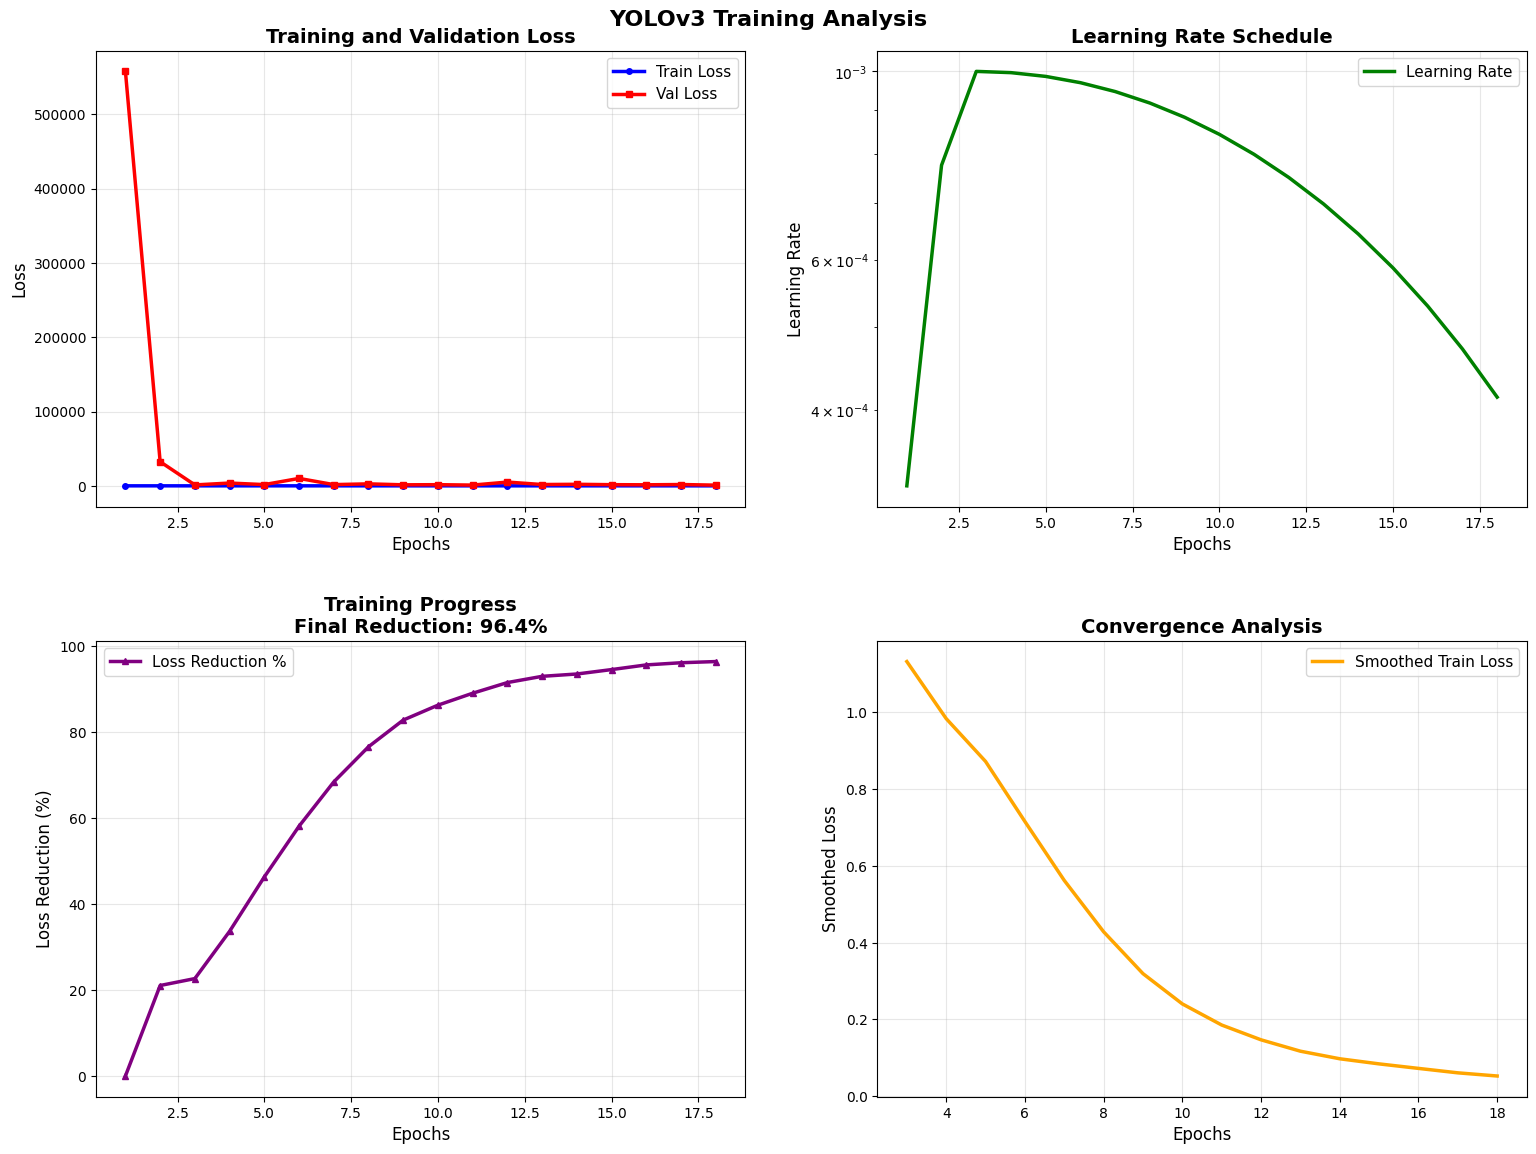

TRAINING SUMMARY
Total Epochs: 18
Initial Training Loss: 1.3259
Final Training Loss: 0.0479
Best Validation Loss: 930.7093
Loss Reduction: 96.4%
Final Learning Rate: 4.14e-04
Convergence Status: EXCELLENT


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def plot_training_analysis(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    learning_rates = checkpoint['learning_rates']

    epochs_range = range(1, len(train_losses) + 1)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Training and Validation Loss
    ax1.plot(epochs_range, train_losses, 'b-', linewidth=2.5, label='Train Loss', marker='o', markersize=4)
    ax1.plot(epochs_range, val_losses, 'r-', linewidth=2.5, label='Val Loss', marker='s', markersize=4)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # Plot 2: Learning Rate Schedule
    ax2.plot(epochs_range, learning_rates, 'g-', linewidth=2.5, label='Learning Rate')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    # Plot 3: Loss Reduction Percentage
    initial_loss = train_losses[0]
    loss_reductions = [((initial_loss - loss) / initial_loss * 100) for loss in train_losses]
    final_reduction = loss_reductions[-1]

    ax3.plot(epochs_range, loss_reductions, 'purple', linewidth=2.5, label='Loss Reduction %', marker='^', markersize=5)
    ax3.set_xlabel('Epochs', fontsize=12)
    ax3.set_ylabel('Loss Reduction (%)', fontsize=12)
    ax3.set_title(f'Training Progress\nFinal Reduction: {final_reduction:.1f}%', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='both', which='major', labelsize=10)

    # Plot 4: Smoothed Loss Curve (Convergence Analysis)
    if len(train_losses) > 3:
        window = 3
        smoothed_losses = np.convolve(train_losses, np.ones(window)/window, mode='valid')
        smoothed_epochs = range(window, len(train_losses) + 1)
        ax4.plot(smoothed_epochs, smoothed_losses, 'orange', linewidth=2.5, label='Smoothed Train Loss')
        ax4.set_xlabel('Epochs', fontsize=12)
        ax4.set_ylabel('Smoothed Loss', fontsize=12)
        ax4.set_title('Convergence Analysis', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=11)
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='both', which='major', labelsize=10)
    else:
        ax4.text(0.5, 0.5, 'Not enough data\nfor convergence analysis',
                horizontalalignment='center', verticalalignment='center',
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Convergence Analysis', fontsize=14, fontweight='bold')

    # Adjust layout
    plt.tight_layout(pad=3.0)

    # Add overall title
    fig.suptitle('YOLOv3 Training Analysis', fontsize=16, fontweight='bold', y=0.98)

    plt.show()

    # Print detailed summary
    print("="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Epochs: {len(train_losses)}")
    print(f"Initial Training Loss: {train_losses[0]:.4f}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Best Validation Loss: {min(val_losses):.4f}")
    print(f"Loss Reduction: {final_reduction:.1f}%")
    print(f"Final Learning Rate: {learning_rates[-1]:.2e}")

    # Convergence status
    if final_reduction > 95:
        status = "EXCELLENT"
    elif final_reduction > 80:
        status = "GOOD"
    elif final_reduction > 60:
        status = "FAIR"
    else:
        status = "POOR"

    print(f"Convergence Status: {status}")
    print("="*60)

# Usage
checkpoint_path = "/content/drive/MyDrive/fyp/checkpoints/best_model.pth"
print(f"Loading checkpoint from: {checkpoint_path}")

try:
    plot_training_analysis(checkpoint_path)
except FileNotFoundError:
    print("Checkpoint file not found. Please check the path.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

testing

In [ ]:
import torch
import numpy as np

class SimpleYOLOEvaluator:
    def __init__(self, model, device, num_classes=5, iou_threshold=0.5):
        self.model = model
        self.device = device
        self.num_classes = num_classes
        self.iou_threshold = iou_threshold
        self.class_names = ['Knife', 'Scissors', 'Pliers', 'Gun', 'Wrench']
        self.model.eval()

    def calculate_iou(self, box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection

        return intersection / (union + 1e-6)

    def decode_predictions(self, predictions, conf_threshold=0.5):
        all_detections = []

        for scale_pred in predictions:
            B, A, C, H, W = scale_pred.shape
            scale_pred = scale_pred.permute(0, 1, 3, 4, 2).contiguous()

            for b in range(B):
                detections = []
                for i in range(H):
                    for j in range(W):
                        for a in range(A):
                            pred = scale_pred[b, a, j, i]

                            obj_score = torch.sigmoid(pred[4])
                            if obj_score < conf_threshold:
                                continue

                            class_probs = torch.sigmoid(pred[5:])
                            class_score, class_id = torch.max(class_probs, 0)
                            confidence = obj_score * class_score

                            if confidence < conf_threshold:
                                continue

                            x = (torch.sigmoid(pred[0]) + i) / W
                            y = (torch.sigmoid(pred[1]) + j) / H
                            w = torch.exp(pred[2]) / W
                            h = torch.exp(pred[3]) / H

                            x1 = (x - w/2)
                            y1 = (y - h/2)
                            x2 = (x + w/2)
                            y2 = (y + h/2)

                            detections.append({
                                'class_id': class_id.item(),
                                'confidence': confidence.item(),
                                'bbox': [x1, y1, x2, y2]
                            })
                all_detections.append(detections)

        return all_detections

    def evaluate_map(self, val_loader, conf_threshold=0.5):
        all_detections = []
        all_ground_truths = []

        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(self.device)
                targets = [t.to(self.device) for t in targets]

                outputs = self.model(images)
                batch_detections = self.decode_predictions(outputs, conf_threshold)

                batch_ground_truths = []
                for target in targets:
                    gt_boxes = []
                    for i in range(len(target)):
                        cls_id = int(target[i, 0])
                        x_center, y_center, width, height = target[i, 1:5]
                        x1 = x_center - width/2
                        y1 = y_center - height/2
                        x2 = x_center + width/2
                        y2 = y_center + height/2
                        gt_boxes.append([cls_id, x1.item(), y1.item(), x2.item(), y2.item()])
                    batch_ground_truths.append(gt_boxes)

                all_detections.extend(batch_detections)
                all_ground_truths.extend(batch_ground_truths)

        # Calculate metrics per class
        aps = []
        precisions = []
        recalls = []
        f1_scores = []

        for class_id in range(self.num_classes):
            tp, fp, fn = 0, 0, 0

            for detections, ground_truths in zip(all_detections, all_ground_truths):
                class_detections = [d for d in detections if d['class_id'] == class_id]
                class_ground_truths = [gt for gt in ground_truths if gt[0] == class_id]

                class_detections.sort(key=lambda x: x['confidence'], reverse=True)

                matched_gt = [False] * len(class_ground_truths)

                for detection in class_detections:
                    best_iou = 0
                    best_gt_idx = -1

                    for gt_idx, gt in enumerate(class_ground_truths):
                        if matched_gt[gt_idx]:
                            continue

                        iou = self.calculate_iou(detection['bbox'], gt[1:])
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                    if best_iou >= self.iou_threshold and best_gt_idx != -1:
                        tp += 1
                        matched_gt[best_gt_idx] = True
                    else:
                        fp += 1

                fn += len(class_ground_truths) - sum(matched_gt)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            # Simple AP calculation (precision at different recall points)
            ap = precision  # Simplified for this implementation

            aps.append(ap)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        map_score = np.mean(aps)

        # Overall metrics
        total_tp = sum([precisions[i] * (precisions[i] > 0) for i in range(self.num_classes)])
        total_fp = sum([(1 - precisions[i]) * (precisions[i] > 0) for i in range(self.num_classes)])
        total_fn = sum([(1 - recalls[i]) * (recalls[i] > 0) for i in range(self.num_classes)])

        overall_precision = np.mean(precisions)
        overall_recall = np.mean(recalls)
        overall_f1 = np.mean(f1_scores)

        print("=" * 60)
        print("EVALUATION RESULTS")
        print("=" * 60)
        print(f"mAP@0.5: {map_score:.4f}")
        print(f"Precision: {overall_precision:.4f}")
        print(f"Recall: {overall_recall:.4f}")
        print(f"F1-Score: {overall_f1:.4f}")
        print()

        print("Per-class metrics:")
        print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AP':<10}")
        print("-" * 50)
        for i in range(self.num_classes):
            print(f"{self.class_names[i]:<12} {precisions[i]:.4f}    {recalls[i]:.4f}    {f1_scores[i]:.4f}    {aps[i]:.4f}")

        print("=" * 60)

        return {
            'map': map_score,
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1,
            'per_class': {
                'precisions': precisions,
                'recalls': recalls,
                'f1_scores': f1_scores,
                'aps': aps
            }
        }

# Usage
print("Initializing evaluator...")
evaluator = SimpleYOLOEvaluator(model, device, num_classes=5, iou_threshold=0.5)

print("Starting evaluation...")
results = evaluator.evaluate_map(val_loader, conf_threshold=0.5)

print("Evaluation completed!")

Initializing evaluator...
Starting evaluation...
EVALUATION RESULTS
mAP@0.5: 0.0000
Precision: 0.0000
Recall: 0.0016
F1-Score: 0.0000

Per-class metrics:
Class        Precision  Recall     F1-Score   AP        
--------------------------------------------------
Knife        0.0000    0.0000    0.0000    0.0000
Scissors     0.0000    0.0000    0.0000    0.0000
Pliers       0.0000    0.0081    0.0000    0.0000
Gun          0.0000    0.0000    0.0000    0.0000
Wrench       0.0000    0.0000    0.0000    0.0000
Evaluation completed!
